# Main Script



#### Needed Imports

In [5]:
#Installo le librerie
%pip install -U seaborn
%pip install --upgrade keras
%pip install --upgrade tensorflow
%pip install pickle5
%pip install tensorboard
%pip install torch
%pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached pickle5-0.0.11.tar.gz (132 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for pickle5
Failed to build pickle5
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [17 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-312
      creating build\lib.win-amd64-cpython-312\pickle5
      copying pickle5\pickle.py -> build\lib.win-amd64-cpython-312\pickle5
      copying pickle5\pickletools.py -> build\lib.win-amd64-cpython-312\pickle5
      copying pickle5\__init__.py -> build\lib.win-amd64-cpython-312\pickle5
      creating build\lib.win-amd64-cpython-312\pickle5\test
      copying pickle5\test\pickletester.py -> build\lib.win-amd64-cpython-312\pickle5\test
      copying pickle5\test\test_pickle.py -> build\lib.win-amd64-cpython-312\pickle5\test
      copying pickle5\test\test_picklebuffer.py -> build\lib.win-amd64-cpython-312\pickle5\test
      copying pickle5\test\__init__.py -> build\lib.win-amd64-cpython-312\pickle5\test
      run

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ---------------------------------------- 0.0/60.6 kB ? eta -:--:--
     -------------------- ------------------- 30.7/60.6 kB 1.3 MB/s eta 0:00:01
     ---------------------------------------- 60.6/60.6 kB 1.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/10.9 MB ? eta -:--:--
    --------------------------------------- 0.2/10.9 MB 5.9 MB/s eta 0:00:02
   --- ------------------------------------ 0.9/10.9 MB 11.4 MB/s eta 0:00:01
   ---------------- ----------------------- 4.6/10.9 MB 36.7 MB/s eta 0:00:01
   ---------------------------- ----------- 7.8/10.9 MB 50.1 MB/s eta 0:00:01
   ---------------------------- ----------- 7.8/10.9 MB 50.1 MB/s eta 0:00:01
   ---------------------------------------  10.9/10.9 MB 59.5 MB/s eta 0:00:01
   ---------------------------------------- 10.9/10.9 MB 50.1 MB/s eta 0:00:00
   ----------------

In [6]:
#Import delle Librerie
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import iqr
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
import scipy.stats as stats
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.model_selection import train_test_split
import pickle
import random
import os
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score,make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#### Loading data from data_loader.py

In [7]:
# CSV zip folder's path
csv_file_name = '../data.zip'

# loading data from csv
data = pd.read_csv(csv_file_name)

In [ ]:
# CSV zip folder's path
csv_file_name = '/content/drive/MyDrive/Colab Notebooks/data.zip'

# loading data from csv
data = pd.read_csv(csv_file_name)

In [8]:
len(data)

252175

---
#### Data Acquisition

#### Describing data

In [9]:
#print shape of dataset
print("Dataset shape:",data.shape) #25175 row, 91 columns. We know that the label Y ('year) is the first one column.

# saving data without first column 'year'
no_target_column_data = data[data.columns[1:]]
print(no_target_column_data.describe())

Dataset shape: (252175, 91)
                  S0             S1             S2             S3  \
count  252175.000000  252175.000000  252175.000000  252175.000000   
mean       43.379379       1.555258       8.643927       1.160078   
std         6.066547      51.551085      35.235495      16.336577   
min         3.455260    -334.953220    -301.005060    -149.962040   
25%        39.959775     -25.651750     -11.524900      -8.492585   
50%        44.250440       8.655610      10.516440      -0.641920   
75%        47.822515      36.248650      29.792790       8.766685   
max        61.970140     384.065730     318.868960     228.412110   

                  S4             S5             S6             S7  \
count  252175.000000  252175.000000  252175.000000  252175.000000   
mean       -6.526075      -9.532049      -2.366866      -1.788645   
std        22.841967      12.809154      14.530697       7.963275   
min      -181.953370     -72.717370    -111.017810     -68.404510   
25%  

In [15]:
#Descrizione database
data.info() #Non ci sono valori mancanti e tutte le colonne dello stesso tipo (float64) ad eccezione della colonna 'Year' (int64)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252175 entries, 0 to 252174
Data columns (total 91 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Year    252175 non-null  int64  
 1   S0      252175 non-null  float64
 2   S1      252175 non-null  float64
 3   S2      252175 non-null  float64
 4   S3      252175 non-null  float64
 5   S4      252175 non-null  float64
 6   S5      252175 non-null  float64
 7   S6      252175 non-null  float64
 8   S7      252175 non-null  float64
 9   S8      252175 non-null  float64
 10  S9      252175 non-null  float64
 11  S10     252175 non-null  float64
 12  S11     252175 non-null  float64
 13  S12     252175 non-null  float64
 14  S13     252175 non-null  float64
 15  S14     252175 non-null  float64
 16  S15     252175 non-null  float64
 17  S16     252175 non-null  float64
 18  S17     252175 non-null  float64
 19  S18     252175 non-null  float64
 20  S19     252175 non-null  float64
 21  S20     25

In [10]:
target_label = data[data.columns[:1]]

#### Data by target column 'Year'

Sono presenti righe con categorie della colonna target 'Year' che vanno dal 1956 al 2009.

C'è uno sbilanciamento del dataset, che presenta molte più righe (e per cui canzoni e features su cui verranno allenati i modelli) per gli anni dal (circa) 1990 in poi.

Infatti, nel dataset per il 1990 stesso ci sono 3628 righe, per il 2000 ce ne sono più di 9mila e per il 2009 (anno maggiore == più vicino nel tempo all'anno odierno) ce ne sono più di 15mila.
In generale per gli anni 2000 ci sono circa più di 10mila righe, per gli altri, allontanandosi sempre più indietro nel tempo, ce ne sono sempre meno fino a toccare un minimodi circa 200 / 300.

E' necessario bilanciare il dataset o comunque affidare dei pesi ad ogni categoria / classe in modo tale che il training sia bilanciato in base ai dati a nostra disposizione.

In [11]:
sorted_data_by_year = data.sort_values(by='Year')

year_count = sorted_data_by_year['Year'].value_counts()
print(year_count.sort_index())

Year
1956      283
1957      299
1958      291
1959      296
1960      212
1961      285
1962      302
1963      451
1964      473
1965      560
1966      689
1967      859
1968      934
1969     1105
1970     1174
1971     1065
1972     1144
1973     1298
1974     1092
1975     1241
1976     1089
1977     1251
1978     1463
1979     1554
1980     1551
1981     1581
1982     1798
1983     1693
1984     1684
1985     1789
1986     2110
1987     2561
1988     2805
1989     3335
1990     3628
1991     4323
1992     4771
1993     5263
1994     6061
1995     6629
1996     7065
1997     7591
1998     7907
1999     9119
2000     9642
2001    10795
2002    11726
2003    13691
2004    14803
2005    17476
2006    18767
2007    19702
2008    17380
2009    15519
Name: count, dtype: int64


In [12]:
infos=sorted_data_by_year.groupby('Year')
print(infos.describe())

           S0                                                                  \
        count       mean       std       min        25%        50%        75%   
Year                                                                            
1956    283.0  37.918317  6.360809  18.85936  34.160860  38.520610  42.777765   
1957    299.0  37.294501  6.540781  16.74940  33.014035  37.968080  42.231905   
1958    291.0  39.184471  5.760782  20.37114  35.591150  40.144380  43.481665   
1959    296.0  39.335948  5.538941  19.65088  35.905565  39.455235  43.312650   
1960    212.0  38.639910  5.091828  20.15428  35.462605  38.815100  42.417372   
1961    285.0  40.020702  5.230869  22.58792  36.956810  40.359160  43.613700   
1962    302.0  39.875598  5.279745  19.04782  36.942355  40.615420  43.641865   
1963    451.0  40.484300  5.043114  23.38250  37.397185  40.711390  44.273985   
1964    473.0  40.310878  6.289511  11.32260  36.386380  41.537300  44.805450   
1965    560.0  40.712386  5.

---
#### Data visualization

##### Density plot

In [ ]:
#Funzione Density Plot/Histogramma per tutte le colonne del dataset

def plot_density(dataset, columns_per_row=4, figsize=(15, 10)):
   
    num_columns =data.shape[1]
    num_rows = (num_columns - 1) // columns_per_row + 1
    
    fig, axes = plt.subplots(num_rows, columns_per_row, figsize=figsize)
    axes = axes.flatten()
    
    for i, column in enumerate(dataset.columns):
        ax = axes[i]
        ax.set_title(column)
        ax.hist(dataset[column], density=True, bins=30, alpha=0.5)
        dataset[column].plot(kind='kde', ax=ax, color='blue')
        
    for ax in axes[num_columns:]:
        ax.axis('off')  # Nasconde gli assi per le eventuali celle vuote
        
    plt.tight_layout()
    plt.show()

# Utilizzo della funzione 
plot_density(data.iloc[:,1:], columns_per_row=4, figsize=(55, 50))


Dal density plot notiamo come non sia presente una distribuzione gaussiana dei dati.

##### Box plot

In [ ]:
# Box plot
plt.figure(figsize=(20, 8))
sns.boxplot(data=no_target_column_data, orient='v')  # orient='v' indica un boxplot verticale

# Aggiunta di etichette all'asse x
plt.xticks(rotation=90)  # Puoi regolare l'angolo di inclinazione delle etichette per una migliore leggibilità

# Titoli e etichette degli assi
plt.xlabel('Features')
plt.ylabel('Values')

# Visualizzazione del boxplot
plt.show()

In [ ]:
# Box plot S0 to S12
plt.figure(figsize=(10, 12))
sns.boxplot(data=no_target_column_data.iloc[:,0:13], orient='v')  # orient='v' indica un boxplot verticale

# Aggiunta di etichette all'asse x
plt.xticks(rotation=90)  # Puoi regolare l'angolo di inclinazione delle etichette per una migliore leggibilità

# Titoli e etichette degli assi
plt.xlabel('Features')
plt.ylabel('Values')

# Visualizzazione del boxplot
plt.show()

In [ ]:
# Box plot S13 to S23
plt.figure(figsize=(10, 15))
sns.boxplot(data=no_target_column_data.iloc[:,13:24], orient='v')  # orient='v' indica un boxplot verticale

# Aggiunta di etichette all'asse x
plt.xticks(rotation=90)  # Puoi regolare l'angolo di inclinazione delle etichette per una migliore leggibilità

# Titoli e etichette degli assi
plt.xlabel('Features')
plt.ylabel('Values')

# Visualizzazione del boxplot
plt.show()

In [ ]:
# Box plot S24 to S34
plt.figure(figsize=(10, 17))
sns.boxplot(data=no_target_column_data.iloc[:,24:35], orient='v')  # orient='v' indica un boxplot verticale

# Aggiunta di etichette all'asse x
plt.xticks(rotation=90)  # Puoi regolare l'angolo di inclinazione delle etichette per una migliore leggibilità

# Titoli e etichette degli assi
plt.xlabel('Features')
plt.ylabel('Values')

# Visualizzazione del boxplot
plt.show()

In [ ]:
# Box plot S35 to S45
plt.figure(figsize=(10, 17))
sns.boxplot(data=no_target_column_data.iloc[:,35:46], orient='v')  # orient='v' indica un boxplot verticale

# Aggiunta di etichette all'asse x
plt.xticks(rotation=90)  # Puoi regolare l'angolo di inclinazione delle etichette per una migliore leggibilità

# Titoli e etichette degli assi
plt.xlabel('Features')
plt.ylabel('Values')

# Visualizzazione del boxplot
plt.show()

In [ ]:
# Box plot S46 to S54
plt.figure(figsize=(10, 12))
sns.boxplot(data=no_target_column_data.iloc[:,46:55], orient='v')  # orient='v' indica un boxplot verticale

# Aggiunta di etichette all'asse x
plt.xticks(rotation=90)  # Puoi regolare l'angolo di inclinazione delle etichette per una migliore leggibilità

# Titoli e etichette degli assi
plt.xlabel('Features')
plt.ylabel('Values')

# Visualizzazione del boxplot
plt.show()

In [ ]:
# Box plot S55 to S64
plt.figure(figsize=(10, 12))
sns.boxplot(data=no_target_column_data.iloc[:,55:65], orient='v')  # orient='v' indica un boxplot verticale

# Aggiunta di etichette all'asse x
plt.xticks(rotation=90)  # Puoi regolare l'angolo di inclinazione delle etichette per una migliore leggibilità

# Titoli e etichette degli assi
plt.xlabel('Features')
plt.ylabel('Values')

# Visualizzazione del boxplot
plt.show()

In [ ]:
# Box plot S65 to S75
plt.figure(figsize=(10, 12))
sns.boxplot(data=no_target_column_data.iloc[:,65:76], orient='v')  # orient='v' indica un boxplot verticale

# Aggiunta di etichette all'asse x
plt.xticks(rotation=90)  # Puoi regolare l'angolo di inclinazione delle etichette per una migliore leggibilità

# Titoli e etichette degli assi
plt.xlabel('Features')
plt.ylabel('Values')

# Visualizzazione del boxplot
plt.show()

In [ ]:
# Box plot S76 to S82
plt.figure(figsize=(10, 12))
sns.boxplot(data=no_target_column_data.iloc[:,76:83], orient='v')  # orient='v' indica un boxplot verticale

# Aggiunta di etichette all'asse x
plt.xticks(rotation=90)  # Puoi regolare l'angolo di inclinazione delle etichette per una migliore leggibilità

# Titoli e etichette degli assi
plt.xlabel('Features')
plt.ylabel('Values')

# Visualizzazione del boxplot
plt.show()

In [ ]:
# Box plot S83 to S89
plt.figure(figsize=(10, 12))
sns.boxplot(data=no_target_column_data.iloc[:,83:90], orient='v')  # orient='v' indica un boxplot verticale

# Aggiunta di etichette all'asse x
plt.xticks(rotation=90)  # Puoi regolare l'angolo di inclinazione delle etichette per una migliore leggibilità

# Titoli e etichette degli assi
plt.xlabel('Features')
plt.ylabel('Values')

# Visualizzazione del boxplot
plt.show()

Nei **Boxplots** che abbiamo mostrato qua sopra, si possono notare come le features hanno una distribuzione di dati simile per quasi tutte le colonne, tranne per quelle che vanno da: *S0* a *S12*. Sono presenti, per ogni features, un gran numero di *outliers* sia sotto i valori minimi sia sopra i valori massimi del boxplot.



##### Correlation Matrix

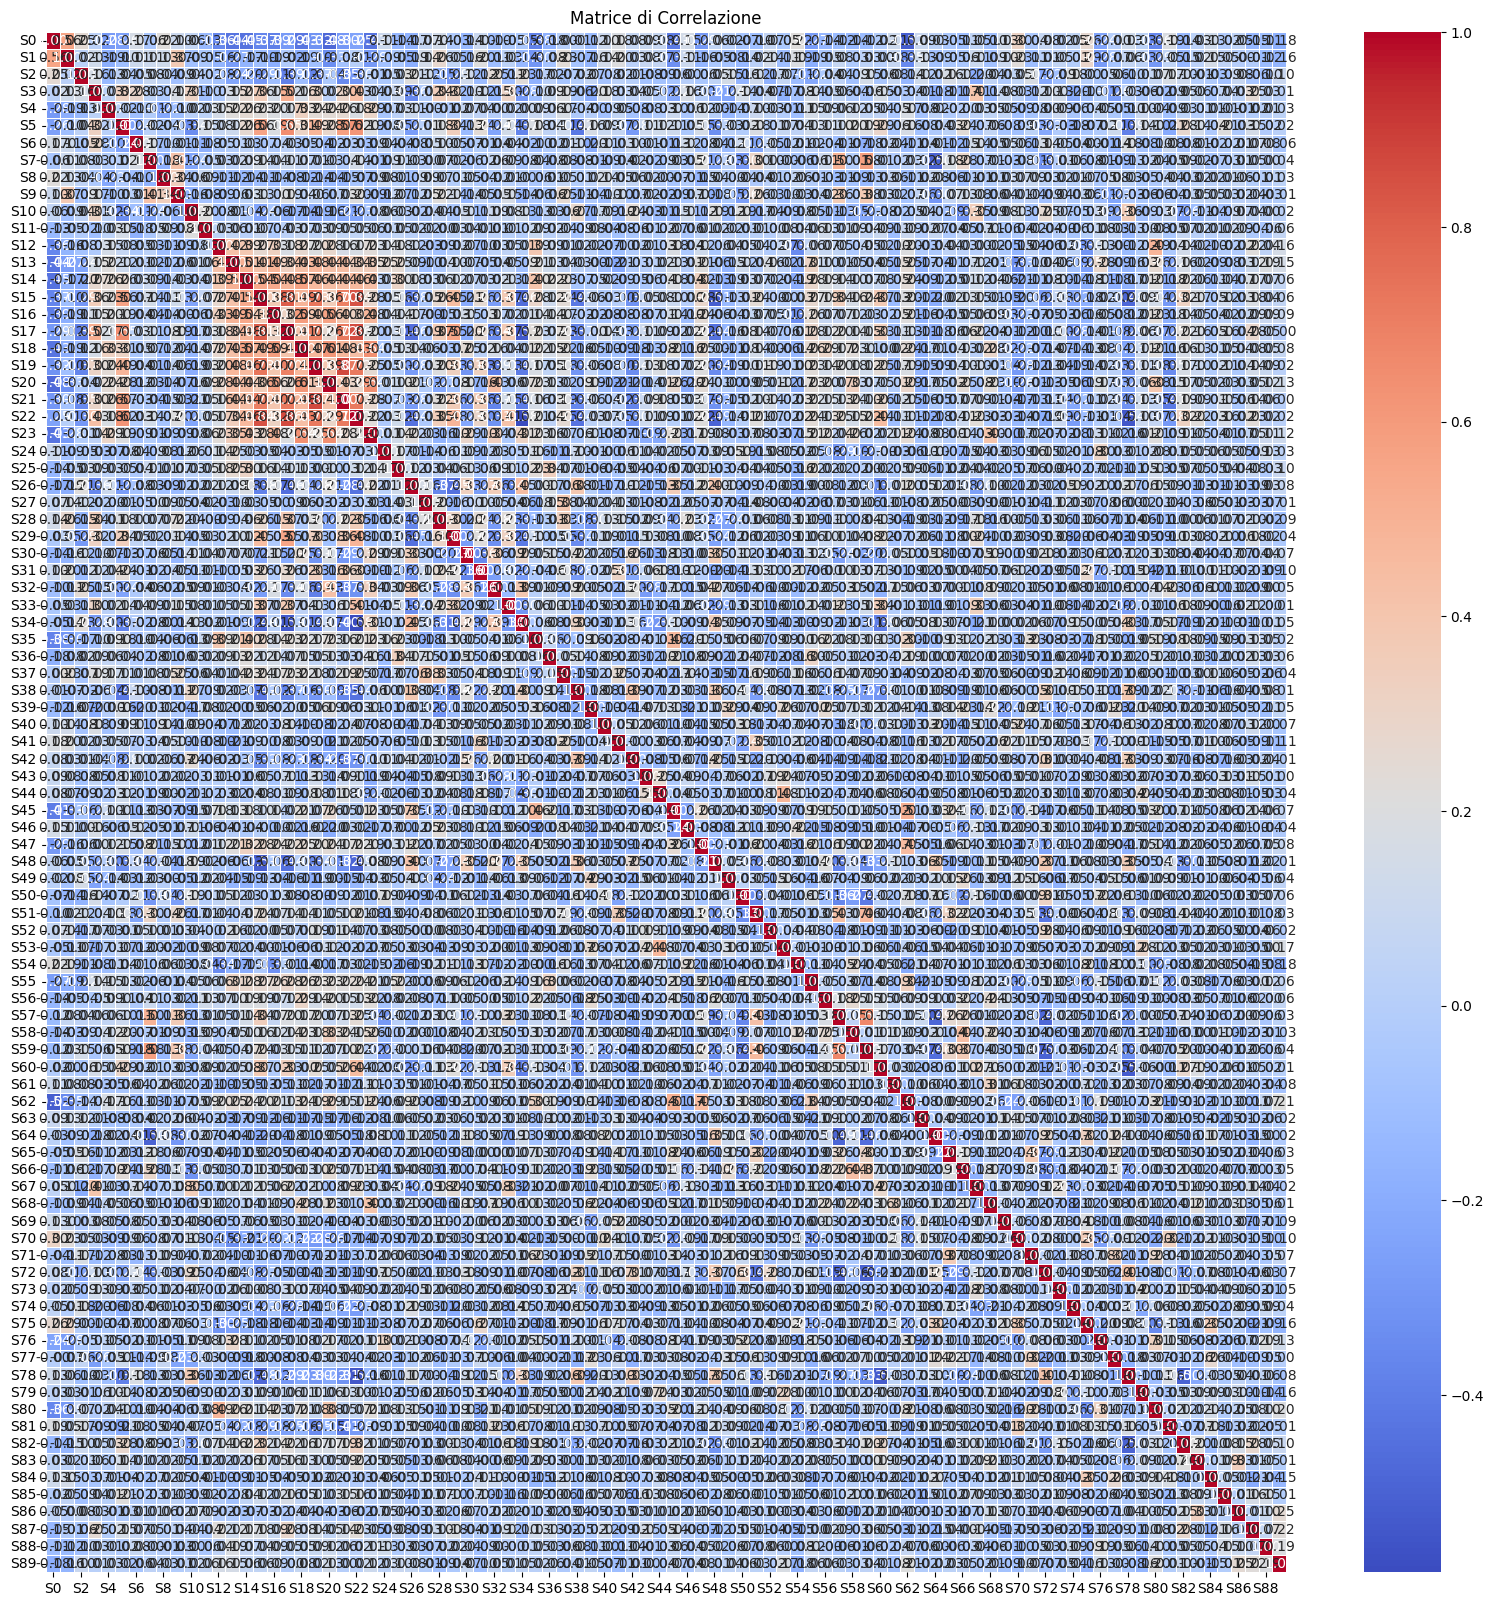

In [14]:
# Calcolare la matrice di correlazione
correlation_matrix = no_target_column_data.corr()

# Creare una heatmap della matrice di correlazione usando seaborn
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matrice di Correlazione')
plt.show()

In [ ]:
# Eliminare i coefficienti di correlazione uguali a 1
correlation_matrix = correlation_matrix.mask(correlation_matrix == 1)

# Estrarre le prime 20 coppie con i coefficienti di correlazione più alti
top_corr_pairs = correlation_matrix.unstack().nlargest(40)

# Stampa i nomi delle colonne delle prime 20 coppie
print("Nomi delle colonne delle prime 20 coppie con coefficiente di correlazione più alto:")
for (var1, var2), corr in top_corr_pairs.items():
    print(f"{var1} e {var2}, Correlazione: {corr}")
    print(f"Nomi delle colonne: {var1}, {var2}")
    print()

##### Correlation matrix su tutto il dataset
Data la correlation matrix riportata sopra abbiamo notato come vi sia una forte relazione tra le colonne da S12 a S24 circa, che sono caratterizzate da una forte presenza di valori outlier (lo abbiamo visto dai boxplot).
Dunque, proviamo anche a calcolare la correlation matrix escludendo queste colonne.

In [ ]:
subset_data = pd.concat([no_target_column_data.iloc[:,:12], no_target_column_data.iloc[:,24:]], axis=1)

# Calcolare la matrice di correlazione
correlation_matrix = subset_data.corr()

# Creare una heatmap della matrice di correlazione usando seaborn
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matrice di Correlazione')
plt.show()

In [ ]:
# Eliminare i coefficienti di correlazione uguali a 1
correlation_matrix = correlation_matrix.mask(correlation_matrix == 1)

# Estrarre le prime 20 coppie con i coefficienti di correlazione più alti
top_corr_pairs = correlation_matrix.unstack().nlargest(40)

# Stampa i nomi delle colonne delle prime 20 coppie
print("Nomi delle colonne delle prime 20 coppie con coefficiente di correlazione più alto:")
for (var1, var2), corr in top_corr_pairs.items():
    print(f"{var1} e {var2}, Correlazione: {corr}")
    print(f"Nomi delle colonne: {var1}, {var2}")
    print()

##### Correlation matrix (S12:S24 escluse)
In questa correlation matrix notiamo come i coefficienti di correlazione siano effettivamente più bassi, evidenziando il fatto che le variabili non sono correlate nello stesso modo in cui lo sono quelle dalla 12 alla 24.

Dobbiamo dunque trattare gli outlier prima di poter stabilire quali variabili siano più rilevanti rispetto alle altre.

##### Conclusioni dopo data visualization
Dal processo di visualizzazione dei dati deduciamo che è necessario trattare gli *outliers*: consideriamo quindi che non siano rilevanti per l'allenamento del nostro modello, ma si tratti di dati rumorosi e fuorvianti.

In ogni caso valutare allenamento modelli con outliers.

Valutare problema di **High Dimensionality**: tramite PCA (Princial Component Analysis) e LDA (Linear Discrimination Analysis)

Valutare **Normalizzazione**: vedendo la distribuzione non gaussiana, opterei per **MinMaxScaling** (non escludere *Standardization*)

##### Trattamento outliers by winsorization

In [ ]:
no_target_column_smoothed_data = pd.DataFrame(no_target_column_data.copy())

def winsorize_column(column, k=1.5):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - k * iqr
    upper_bound = q3 + k * iqr
    column = np.where(column < lower_bound, lower_bound, column)
    column = np.where(column > upper_bound, upper_bound, column)
    return column

for column in no_target_column_smoothed_data.columns:
  no_target_column_smoothed_data[column] = winsorize_column(no_target_column_smoothed_data[column])

#### Z-SCORE (remove outliers) (su tutto il DATASET) MSE (post MinMaxScaling): 36.398

In [ ]:
def remove_outliers_z_score(dataset, threshold):
    # Copia del dataset per evitare modifiche indesiderate
    cleaned_dataset = dataset.copy()

    # Itera su ogni colonna/feature del dataset
    for column in cleaned_dataset.columns:
        # Calcola lo z-score per la feature corrente
        z_scores = np.abs(stats.zscore(cleaned_dataset[column]))

        # Trova e rimuovi gli outliers superando la soglia
        outliers_indices = np.where(z_scores > threshold)[0]
        cleaned_dataset[column].iloc[outliers_indices] = np.nan

    # Rimuovi righe contenenti valori NaN
    cleaned_dataset = cleaned_dataset.dropna()

    return cleaned_dataset

In [ ]:
# Rimuovi gli outliers utilizzando lo z-score
data_rmoutliers = remove_outliers_z_score(data.copy(), 2)

In [ ]:
data_rmoutliers.shape

In [ ]:
data_rmoutliers.isna().sum().sum() #Restituisce il Num totale dei valori NaN

#### Z-score (sostituzione outliers con MEAN) MSE (post MinMaxScaling) : 41.132

In [ ]:
def replace_outliers_with_mean(dataset, threshold):
    # Copia del dataset per evitare modifiche indesiderate
    cleaned_dataset = dataset.copy()

    # Itera su ogni colonna/feature del dataset
    for column in cleaned_dataset.columns:
        # Calcola lo z-score per la feature corrente
        z_scores = np.abs(stats.zscore(cleaned_dataset[column]))

        # Trova gli outliers superando la soglia
        outliers_indices = np.where(z_scores > threshold)[0]

        # Sostituisci gli outliers con la media della colonna
        column_mean = cleaned_dataset[column].mean()
        cleaned_dataset[column].iloc[outliers_indices] = column_mean

    return cleaned_dataset

In [ ]:
# Sostituisci gli outliers con la media delle colonne
data_rmoutliers = replace_outliers_with_mean(data, 2)

In [ ]:
data_rmoutliers.shape

In [ ]:
data_rmoutliers.isna().sum().sum() #Restituisce il Num totale dei valori NaN

#### Z-SCORE (sostituzione outliers con MEDIAN) : MSE (post MinMaxScaling) : 41.132

In [ ]:
def replace_outliers_with_median(dataset, threshold=3):
    # Copia del dataset per evitare modifiche indesiderate
    cleaned_dataset = dataset.copy()

    # Itera su ogni colonna/feature del dataset
    for column in cleaned_dataset.columns:
        # Calcola lo z-score per la feature corrente
        z_scores = np.abs(stats.zscore(cleaned_dataset[column]))

        # Trova gli outliers superando la soglia
        outliers_indices = np.where(z_scores > threshold)[0]

        # Sostituisci gli outliers con la mediana della colonna
        column_median = cleaned_dataset[column].median()
        cleaned_dataset[column].iloc[outliers_indices] = column_median

    return cleaned_dataset

In [ ]:
# Sostituisci gli outliers con la media delle colonne
data_rmoutliers = replace_outliers_with_mean(data, 2)

In [ ]:
data_rmoutliers.shape

In [ ]:
data_rmoutliers.isna().sum().sum() #Restituisce il Num totale dei valori NaN

#### Preprocessing: suddivisione del dataset

In [ ]:
X = no_target_column_smoothed_data[no_target_column_smoothed_data.columns[1:]]
y = no_target_column_smoothed_data[no_target_column_smoothed_data.columns[:1]]

#### Preprocessing: suddivisione del dataset

In [16]:
X=no_target_column_data.copy() #90 COLONNE
y=target_label.copy()

#### Splitting Dataset: Train & Validation

In [17]:
# X sono le feature (variabili indipendenti), y è la colonna target
# 90% training set - 10% validation set
seed=89
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=seed,stratify=y)

In [18]:
import numpy as np

def find_nan_positions(data):
    nan_positions = np.argwhere(pd.isna(data).to_numpy())
    return nan_positions

nan_positions = find_nan_positions(X_train)

if nan_positions.size > 0:
    print("Valori NaN trovati alle seguenti posizioni:")
    for position in nan_positions:
        print(f"Riga: {position[0] + 1}, Colonna: {position[1] + 1}")
else:
    print("Il DataFrame non contiene valori NaN.")


Il DataFrame non contiene valori NaN.


---
#### Data Preprocessing (LR)


In [19]:
X = X_train.copy()
y = y_val.copy()

##### Boxplot after outliers' smoothing

In [ ]:
# Box plot
plt.figure(figsize=(20, 8))
sns.boxplot(data=X, orient='v')  # orient='v' indica un boxplot verticale

# Aggiunta di etichette all'asse x
plt.xticks(rotation=90)  # Puoi regolare l'angolo di inclinazione delle etichette per una migliore leggibilità

# Titoli e etichette degli assi
plt.xlabel('Features')
plt.ylabel('Values')

# Visualizzazione del boxplot
plt.show()

##### Min max scaling

In [20]:
X_Validation = X_val.copy()

# Min-Max Scaling
# Creazione dell'oggetto MinMaxScaler e adattamento solo al training set
#file = open("scaler.save","wb") #salvataggio dello scaler sul disco nel file "scaler.save"
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
#apply transform on validation set
X_val_scaled = scaler.transform(X_Validation)
#pickle.dump(scaler, file)
#file.close()

#name columns after min-max scaling
# num_colonne = X_scaled.shape[1]  # Ottieni il numero di colonne
# nome_colonne = ['S' + str(i) for i in range(num_colonne)]
# X_scaled_df = pd.DataFrame(X_scaled, columns=nome_colonne)

# print("Dati di training originali:")
# print(X)
print("\nDati di training normalizzati MinMaxScaling:")
print(X_scaled)
# print("\nDati di validation originali:")
# print(X_Validation)
# print("\nDati di validation normalizzati Min-Max:")
# print(X_val_scaled)


Dati di training normalizzati MinMaxScaling:
[[0.71340128 0.51490964 0.4626236  ... 0.53426496 0.51230456 0.33650677]
 [0.58889277 0.45206714 0.43282795 ... 0.51943811 0.50117469 0.36512479]
 [0.62659549 0.49461242 0.49012998 ... 0.51720823 0.50382607 0.32284146]
 ...
 [0.4892453  0.35314902 0.58118535 ... 0.55678682 0.52196309 0.3470155 ]
 [0.73558418 0.42907779 0.55951575 ... 0.50258352 0.50241907 0.32187045]
 [0.61278413 0.46311806 0.39541201 ... 0.47824447 0.50555952 0.31429233]]


#### Standardization

In [ ]:
# standardization of dependent variables
scaler=StandardScaler()
#standardization x_train
X_std = scaler.fit_transform(X) 
#apply transform on validation set
X_val_std = scaler.transform(X_Validation)

##### Boxplot after min max scaling

In [ ]:
# Box plot
plt.figure(figsize=(20, 8))
sns.boxplot(data=X_scaled, orient='v')  # orient='v' indica un boxplot verticale

# Aggiunta di etichette all'asse x
plt.xticks(rotation=90)  # Puoi regolare l'angolo di inclinazione delle etichette per una migliore leggibilità

# Titoli e etichette degli assi
plt.xlabel('Features')
plt.ylabel('Values')

# Visualizzazione del boxplot
plt.show()

##### Density plot after min max scaling

In [ ]:
# Density plot
fig, axs = plt.subplots(15, 3, figsize=(15, 60))
counter = 0

for i in range(15):
  for j in range(3):

    # Plot KDE
    sns.kdeplot(X_scaled[:,counter], ax=axs[i, j], color='g', bw_adjust=2, label='Smooth factor=2')

    # Plot CDF
    sns.kdeplot(X_scaled[:,counter], ax=axs[i, j], color='r', cumulative=True, label='CDF')

    axs[i, j].set_xlabel("S" + str(counter))
    counter = counter+1

plt.show()

##### PCA

##### Studio n_components

In [21]:
num_columns = X_scaled.shape[1]
nums = np.arange(num_columns)

In [22]:
var_ratio = []
for num in nums:
  pca = PCA(n_components=num)
  pca.fit(X_scaled)
  var_ratio.append(np.sum(pca.explained_variance_ratio_))

Text(0.5, 0.85, '95% cut-off threshold')

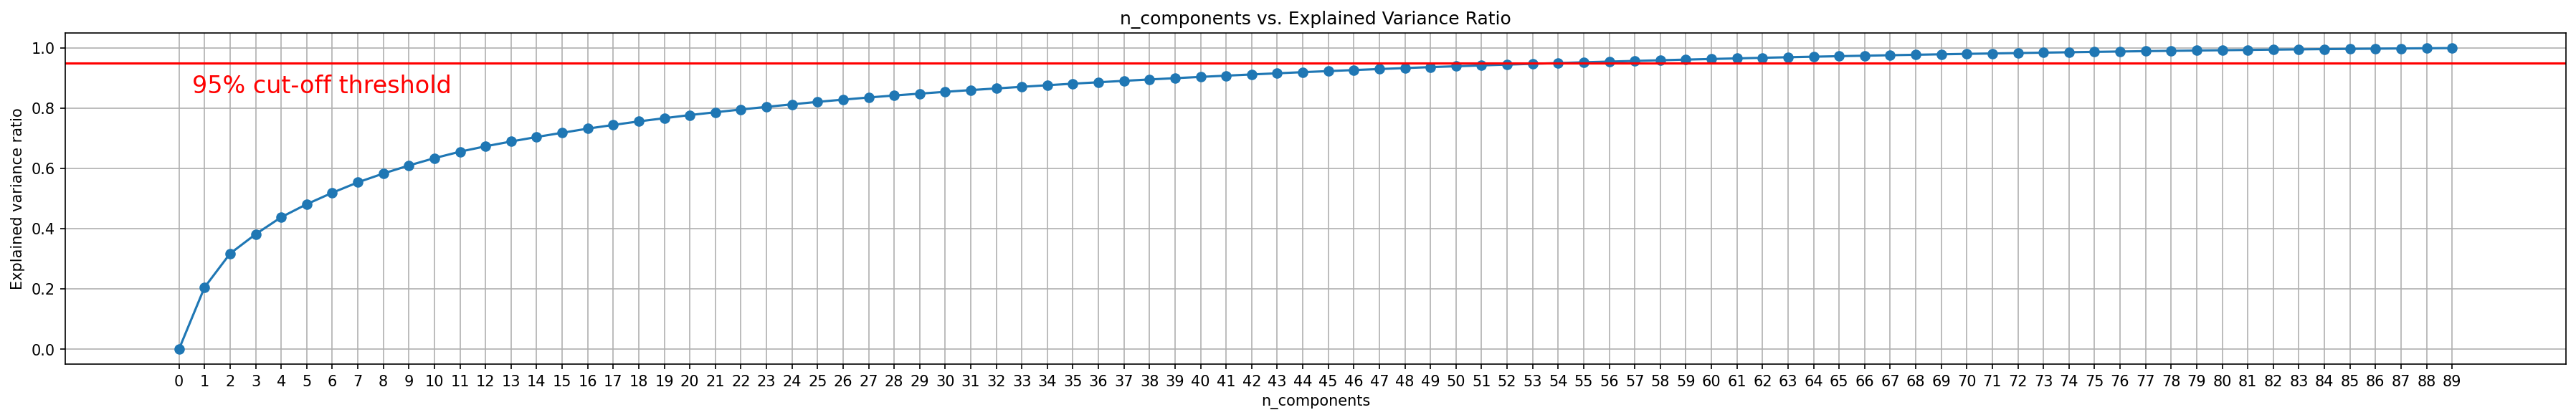

In [23]:
#Dalla Figura si nota come la linea di cutoff del 95% interseca il valore della X nella colonna 51/52
plt.figure(figsize=(30,4),dpi=150)
plt.grid()
plt.plot(nums,var_ratio,marker='o')
plt.xlabel('n_components')
plt.xticks(np.arange(0,90,1))
plt.ylabel('Explained variance ratio')
plt.title('n_components vs. Explained Variance Ratio')
#linea di cutoff del 95%
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

##### PCA Analysis

In [24]:
# Inizializzare l'oggetto PCA
pca = PCA(n_components=52)
X_decomposed = pca.fit_transform(X_scaled)
#pca.get_feature_names_out(X_scaled_df.columns)

# Ottieni i vettori delle componenti principali
components = pca.components_

#validation data after PCA
X_val_decomposed = pca.transform(X_val_scaled)

In [25]:
num_columns=X_decomposed.shape[1]

##### Boxplot after PCA

In [ ]:
# Box plot
plt.figure(figsize=(20, 8))
sns.boxplot(data=X_decomposed, orient='v')  # orient='v' indica un boxplot verticale

# Aggiunta di etichette all'asse x
plt.xticks(rotation=90)  # Puoi regolare l'angolo di inclinazione delle etichette per una migliore leggibilità

# Titoli e etichette degli assi
plt.xlabel('Features')
plt.ylabel('Values')

# Visualizzazione del boxplot
plt.show()

#### Regressione Lineare

In [26]:
##MinMaxScaling(), MSE: 84.500
##MinMaxScaling(),PCA, MSE:86.114

regr = LinearRegression()

# Train the model using the training sets
regr.fit(X_scaled, y_train)

#file = open("Lregression.save","wb")
#pickle.dump(regr, file)
#file.close()

# Make predictions using the testing set
y_predictions = regr.predict(X_val_scaled)
#MSE
mse = mean_squared_error(y_val, y_predictions)
#MAE
mae = mean_absolute_error(y_val, y_predictions)
#MAPE
mape = mean_absolute_percentage_error(y_val, y_predictions)
#R2
r2 = r2_score(y_val, y_predictions)

print("Mean squared error: %.3f" % mse)
print("MAE: %.3f" % mae)
print("MAPE: %.3f" % mape)
print("R2: %.3f" % r2)

Mean squared error: 84.500
MAE: 6.595
MAPE: 0.003
R2: 0.233


#### Cross Validation LR

In [ ]:
# step-1: create a cross-validation scheme
folds=KFold(n_splits=5,shuffle=True,random_state=seed)

# step-2: specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, num_columns+1))}]

# step-3: perform grid search
# 3.1 specify model
lr = LinearRegression()
lr.fit(X_scaled, y_train)
rfe = RFE(lr)             


# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator=rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True) 
# fit the model
model_cv.fit(X_scaled, y_train)     

In [ ]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

In [ ]:
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['val score', 'train score'], loc='upper left')

In [27]:
# final model
n_features_optimal = 50

lm = LinearRegression()
lm.fit(X_scaled, y_train)

rfe = RFE(lm, n_features_to_select=n_features_optimal)             
rfe = rfe.fit(X_train, y_train)

# predict prices of X_val
y_pred = lm.predict(X_val_scaled)

#MSE
mse= mean_squared_error(y_val,y_pred)
#R2_Score
r2 = r2_score(y_val, y_pred)
#MAE
mae = mean_absolute_error(y_val, y_pred)
#MAPE
mape = mean_absolute_percentage_error(y_val, y_pred)

print("MSE after GridSearchCV() with hyperparameter {0}: {1}".format(n_features_optimal,mse))
print("R2 score:",r2)
print("MAE score:",mae)
print("MAPE score:",mape)

# Notice that the val score is very close to the 'mean val score' on the k-folds (about 60%). 
# In general, the mean score estimated by CV will usually be a good estimate of the val score.

MSE after GridSearchCV() with hyperparameter 50: 84.4996815880284
R2 score: 0.2330571091289435
MAE score: 6.595252166595684
MAPE score: 0.0033107089318865353


#### Random Forest Regressor

#### GridSearch RandomForestRegressor

#### Random Forest Regressor con cross validation

In [ ]:


# Definire la grid e la metrica di valutazione
grid1 = {'max_depth': [1, 2, 3, 4],
         'n_estimators': [200, 300,500,1000],
         'random_state': [89]}

# Creare la scorning function
scoring = make_scorer(mean_squared_error, greater_is_better=False)

# Grid Search function
CV_rfr = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid1, cv=5, scoring=scoring)

# Modificare la forma del target y
y_train_reshaped = np.ravel(y_train)

CV_rfr.fit(X_decomposed, y_train_reshaped)

predictions = CV_rfr.predict(X_val_decomposed)
mse = mean_squared_error(y_val, predictions)

# Print results
print("----------BEST PARAMS----------")
print(CV_rfr.best_params_)
print("--------------------------------")
print("Mean squared error: %.3f" % mse)

#-------------MINMAXSCALING (CON PCA=80)------------------
#----------BEST PARAMS----------
#{'max_depth': 4, 'n_estimators': 300, 'random_state': 89}
#Mean squared error: 93.907
#-------------MINMAXSCALING (CON PCA=52)------------------
# ----------BEST PARAMS----------
# {'max_depth': 4, 'n_estimators': 1000, 'random_state': 89}
# --------------------------------
# Mean squared error: 93.910

In [ ]:
# Inizializza il regressore Random Forest
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42,)
new_y = np.ravel(y)
# Calcola l'MSE utilizzando la cross-validation
# cv da modificare --> provare valori più bassi principalmente perchè dataset molto grande
mse_scores = cross_val_score(rf_regressor, X_scaled, y_val, cv=5, scoring='neg_mean_squared_error')

# Calcola l'MSE medio
mse_mean = -mse_scores.mean()

print("Mean Squared Error (MSE):", mse_mean)

#### KNN con GridSearch (Provare con Dati Normalizzati, Rimuovendo Outliers e PCA)

In [ ]:
# Definisci i parametri da testare
# param_grid = {'n_neighbors': [3, 5, 7, 9, 11]} vecchia iterazione
param_grid = {'n_neighbors': list(range(1, 90))}

# Crea un'istanza del modello KNN per la regressione
knn_regressor = KNeighborsRegressor()
y_train_new = np.ravel(y_train)

# Crea un'istanza di GridSearchCV per trovare il miglior parametro
grid_search = GridSearchCV(knn_regressor, param_grid, cv=5, scoring='neg_mean_squared_error')

# Esegui la ricerca dei parametri utilizzando il set di addestramento
grid_search.fit(X_scaled, y_train_new)

# Ottieni il miglior parametro trovato
best_k = grid_search.best_params_['n_neighbors']

# Utilizza il modello addestrato con il miglior parametro per fare previsioni su nuovi dati
best_knn_regressor = grid_search.best_estimator_
y_predictions = best_knn_regressor.predict(X_val_scaled)

scores = []
for i in range(1,100):
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(X_scaled,y_train_new)
    y_pred = knn.predict(X_val_scaled)
    scores.append(accuracy_score(y_val, y_pred))

plt.plot(range(1,16),scores)

# Calcola le metriche di valutazione
mse = mean_squared_error(y_val, y_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_predictions)
mae = mean_absolute_error(y_val, y_predictions)
#MAPE
mape = mean_absolute_percentage_error(y_val, y_predictions)

print("Miglior parametro K:", best_k)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r2)
print("MAE:", mae)
print("MAPE: %.3f" % mape)

### KNN NO GridSearch(Provare con Dati Normalizzati, Rimuovendo Outliers e PCA)

##### NCA (NeighborhoodComponentsAnalysis)

In [ ]:
nca=NeighborhoodComponentsAnalysis(n_components=52,random_state=seed)
X_nca = pca.fit_transform(X_scaled)
#pca.get_feature_names_out(X_scaled_df.columns)

#validation data after PCA
X_val_nca = pca.transform(X_val_scaled)

##### KNN regressor con MinMaxScaling e NCA (no trattamento outliers)

In [ ]:
y_train_new = np.ravel(y_train)

k_values=X_nca.shape[1]


for k in range(1,k_values+1):
    # Crea un'istanza del modello KNN per la regressione al variare di k
    knn_regressor = KNeighborsRegressor(n_neighbors=k)
    knn_regressor.fit(X_decomposed,y_train_new)
    y_pred = knn_regressor.predict(X_val_decomposed)
    #acc_score=accuracy_score(y_val, y_pred)
    # Calcola MSE 
    mse = mean_squared_error(y_val, y_pred)
    print(f"Knn Regresson con k={k}, MSE: {mse} \n")

# MIGLIORE: Knn Regressor,NCA con k=31 e MSE: 76.5093005846459 
# Knn Regressor,Winsorization,NCA con k= e MSE:  Alto
# Knn Regressor,PCA con k= e MSE:  Alto

#### SVM Regressor

In [ ]:
# Definizione della griglia di iperparametri e kernel
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly']
}

y_train_new = np.ravel(y_train)

# Creazione del modello SVR
svr_model = SVR()

# Ricerca Grid per il tuning degli iperparametri e dei kernel
grid_search = GridSearchCV(estimator=svr_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_decomposed, y_train_new)

# Valutazione del modello migliore
best_model = grid_search.best_estimator_
y_predictions = best_model.predict(X_val_decomposed)

# Calcola MSE
mse = mean_squared_error(y_val, y_predictions)
# Calcola RMSE
rmse = np.sqrt(mse)
# Calcola R2 Score
r2 = r2_score(y_val, y_predictions)
# Calcola MAE
mae = mean_absolute_error(y_val, y_predictions)
# Calcola MAPE
mape = mean_absolute_percentage_error(y_val,y_predictions)

print("Best parameters:", grid_search.best_params_)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r2)
print("MAE:", mae)
print("MAPE:", mape)

#### FF (Feed-Forward) reti neurali

In [ ]:
# For reproducibility

def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True  # slower

In [ ]:
# define a simple neural network

class FeedForward(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FeedForward, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.fc2 = nn.Linear(self.hidden_size, num_classes)
        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.relu = nn.ReLU()


    def forward(self, x):
        h = self.fc1(x)
        h = self.relu(h)
        output = self.fc2(h)
        return output

In [ ]:
seed = 89

# Train hyperparameters
num_epochs = 100  # try 100, 200, 500
learning_rate = 0.01
batch = 32

In [ ]:
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_scaled, dtype=torch.float64)
y_train = torch.tensor(y_train, dtype=torch.float64).reshape(-1, 1)
X_val = torch.tensor(X_val_scaled, dtype=torch.float64)
y_val = torch.tensor(y_val, dtype=torch.float64).reshape(-1, 1)

---
#### Data Modeling (tuning hyperparams)


---
#### Performance Evaluation
